## Vapnik-Chervonenkis (VC) Dimension (and Theory)
* necessity to specify the number of parameters (or the complexity) *d* used in the fit 
    * * effective number of parameter useful for some nonlinear models, not fully general
* the VC thoeory provides a general measure of complexity (+ provides bounds on the optimist)
* the VC dimension is a measure of capaciy of a statistical classification algorithm

    * *The VC dimension of the class $\{f(x, \alpha)\}$ is defined to be the largest number of points (in some configuration) that can be shattered by members of $\{f(x, \alpha)\}$*

* Q: what is the VC dimension for KNN with 1 neigbourgh?

* extension to a class of real-valued functions $\{g(x,\alpha)\}$ using the indicator class
    * $\{I(g(x,\alpha) - \beta) > 0\}$, where $\beta$ has values in the range of $g$

* textbook formula $7.56$ gives us optimism bounds
* why are these things useful?
    * important point: the discrepancy between training error and generalization error is bounded from above by a quantity that grows as the model capacity grows but shrinks as the number of training examples increases
* Q: picture of generalization gap (generalization error - training error)
* Q: bounds are rarely used in practical ML, why?

## Cross-Validation (CV)

* method for estimating prediction error
* estimates the extra-sample error $Err = E[L(Y,\hat{f}(X))]$ (the average generalization error)
* CV typically estimates well only the expected prediction error (?)
* [(some) types](https://scikit-learn.org/stable/modules/cross_validation.html) of cross-validation:
    * KFold
        * StratifiedKFold
        * GroupKFold
    * ShuffleSPlit
        * Stratified and Group versions
    * LeaveOneGroupOut
        * LeavePGroupsOut
        * LeaveOneOut
    * LeavePOut (the test sets will overlap for $p > 1$)
    * PredefinedSplit
    
### K-Fold Cross Validation
* data are scarce (hard to learn/estimate and harder to test properly)

In [216]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV, cross_val_score, cross_val_predict, cross_validate, validation_curve, learning_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, accuracy_score, zero_one_loss
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn import datasets

In [153]:
boston = datasets.load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [154]:
pd.DataFrame(boston.data).describe();

In [155]:
X, y = boston['data'], boston['target']
X.shape, y.shape

((506, 13), (506,))

* `cross_validate` as opposed to `cross_val_score`:
    * multiple metrics for eval
    * returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

In [156]:
lm = LinearRegression()
# predictions from cross-validation
predicted = cross_val_predict(lm, boston.data, y, cv=10)

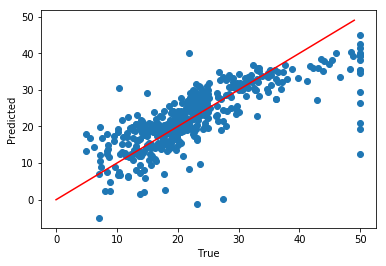

In [158]:
# visualize prediction errors
plt.scatter(y,predicted)
plt.plot(range(0,int(y.max())),range(0,int(y.max())), color = 'r')
plt.xlabel('True')
plt.ylabel('Predicted');

### 10-fold

In [166]:
cv = cross_validate(lm, boston.data, y, cv = 10, scoring = 'neg_mean_squared_error')
test_scores, train_scores = cv['test_score'], cv['train_score']

C:\Users\Analyst1\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


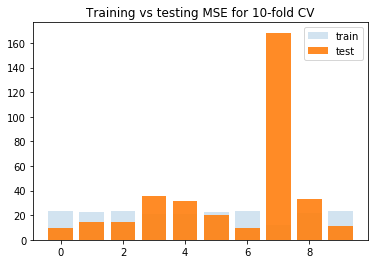

In [168]:
plt.bar(range(0,10), -train_scores, alpha = 0.2)
plt.bar(range(0,10), -test_scores, alpha = 0.9)
plt.legend(['train', 'test'])
plt.title('Training vs testing MSE for 10-fold CV');

### Leave One Out 

In [169]:
cv_loo = cross_validate(lm, boston.data, y, cv = LeaveOneOut(), 
                        scoring = 'neg_mean_squared_error')

In [170]:
test_scores, train_scores = cv_loo['test_score'], cv_loo['train_score']

C:\Users\Analyst1\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


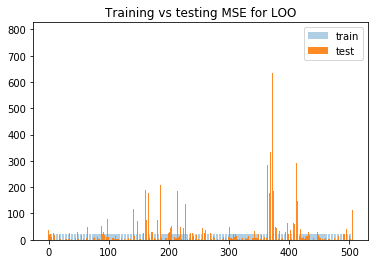

In [173]:
plt.bar(range(0,len(train_scores)), -train_scores, alpha = 0.35)
plt.bar(range(0,len(train_scores)), -test_scores, alpha = 0.9)
plt.legend(['train', 'test'])
plt.title('Training vs testing MSE for LOO');

### Tuning parameters

In [175]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False,
                   scoring = 'neg_mean_squared_error', verbose = 1)

In [176]:
clf.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished
C:\Users\Analyst1\Miniconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [177]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

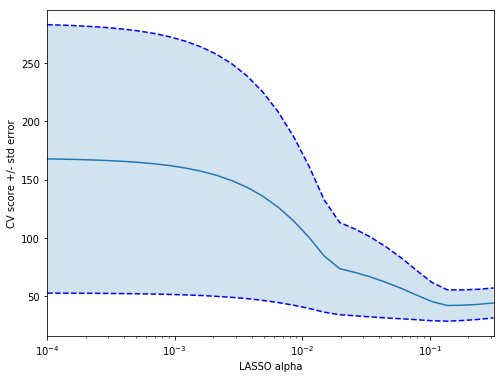

In [185]:
plt.figure().set_size_inches(8, 6)
#  log scaling on x-axis for params
plt.semilogx(alphas, -scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
plt.semilogx(alphas, - scores + std_error, 'b--')
plt.semilogx(alphas, - scores - std_error, 'b--')

# color CI area
plt.fill_between(alphas, - scores + std_error, - scores - std_error, alpha=0.2)
plt.ylabel('CV score +/- std error')
plt.xlabel('LASSO alpha')

# plot limits
plt.xlim([alphas[0], alphas[-1]]);

In [152]:
lasso_cv = LassoCV(alphas=alphas, cv = 10, random_state=0)


# look at how optimal alpha changes according to the crossvalidation
k_fold = KFold(n_splits=10)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print(f"[fold {k}] alpha: {lasso_cv.alpha_}, score: {lasso_cv.score(X[test], y[test])}")   

[fold 0] alpha: 0.011264816923358867, score: 0.7348199450641785
[fold 1] alpha: 0.011264816923358867, score: 0.49704650680669427
[fold 2] alpha: 0.006461670787466976, score: -0.8405368119721562
[fold 3] alpha: 0.31622776601683794, score: 0.5478376060819397
[fold 4] alpha: 0.0004012807031942776, score: 0.5483789907501992
[fold 5] alpha: 0.0196382800192977, score: 0.7482030859525839
[fold 6] alpha: 0.008531678524172814, score: 0.3930951280575855
[fold 7] alpha: 0.2395026619987486, score: -0.03475002453548748
[fold 8] alpha: 0.2395026619987486, score: -0.7074224003762608
[fold 9] alpha: 0.31622776601683794, score: 0.30272737876431977


* also called validation curve, not a nice example..

In [194]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

In [195]:
train_scores, test_scores = validation_curve(
    lasso, X, y, param_name="alpha", param_range=alphas,
    cv=5, scoring = 'neg_mean_squared_error', n_jobs = -1)

train_scores_mean = np.mean(-train_scores, axis=1)
train_scores_std = np.std(-train_scores, axis=1)
test_scores_mean = np.mean(-test_scores, axis=1)
test_scores_std = np.std(-test_scores, axis=1)

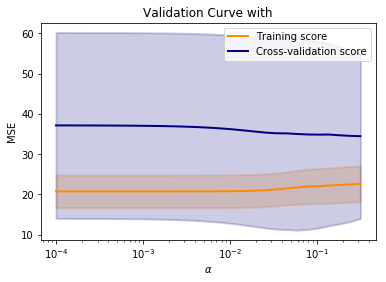

In [197]:
# plot validation curve
plt.title("Validation Curve with")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(alphas, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.fill_between(alphas, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)

plt.semilogx(alphas, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)

plt.fill_between(alphas, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")



* CV only estimates effectively the average error. Why?
    * What value should we choose for K?
        * K = N 
            * approx. unbiased but can have high variance (N "training sets" are similar to one another + computational time
        * e.g. K = 5 
            * lower variance but potentially biased
* learning curves 
     

### Learing curves
* on X axis we have training sample size
* generalization error can be decomposed in terms of bias, variance and noise
    * the bias of an estimator is its average error for different training sets
    * the variance of an estimator indicates how sensitive it is to varying training sets
    * noise is a property of the data

* TODO: define relative error vs. the best model?

In [203]:
alphas = np.logspace(-4, -0.5, 30)
lasso_cv = LassoCV(alphas=alphas, cv = 10, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(
    lasso_cv, X, y, cv = 10, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 20))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Text(0, 0.5, 'Prediction error')

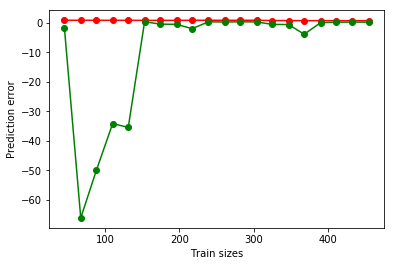

In [199]:
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Training score")
plt.xlabel('Train sizes')
plt.ylabel('Prediction error')

### Generalized cross-validation
* TODO: textbook reference

### The Wrong and Right Way to Do Cross-validation
* true (test) error rate of any classifier is 50% 

In [205]:
N = 50 # n samples
p = 5000 # n predictors
target = np.random.choice([0, 1], size=(N,), p=[0.5, 0.5])
df = np.random.normal(0,1,size = (N,p))

Text(0.5, 1.05, '')

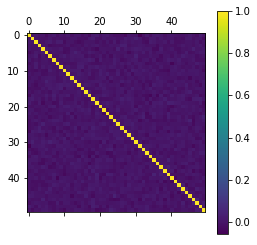

In [206]:
plt.matshow(np.corrcoef(df))
plt.colorbar()
plt.title('')

### Bad way
* TODO: why am I not getting what they are getting? 

In [207]:
# choose 100 predictors with hightest univariate correlation (use corrcoef, because of vectorization) TODO: should this be in absolute value?
q_cutoff = 1 - 100/p
print(q_cutoff)
highest_corr_predictors_mask = np.corrcoef(df.T,target.T)[:,1] > np.quantile(np.corrcoef(df.T,target.T)[:,1],q_cutoff)
highest_corr_predictors_mask = highest_corr_predictors_mask[1:].copy()

highest_corr_predictors = df[:,highest_corr_predictors_mask]

0.98


In [208]:
# using just this subset, build multivariate classifier AND 
KNN = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
KNN_cv_scores = cross_val_score(KNN ,highest_corr_predictors,target, cv=5, scoring = 'accuracy')

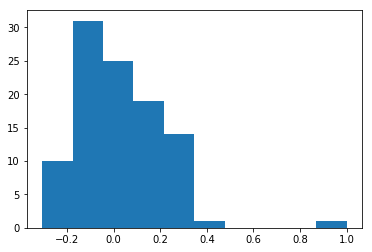

In [209]:
plt.hist(np.corrcoef(highest_corr_predictors.T,target.T)[1,:]);

In [210]:
KNN.fit(df,target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')

In [211]:
KNN.predict(df)

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1])

### Good way
* cross-validation must be applied to the entire sequence of modelling steps
    * exception is doing **unsupervised** screening is possible

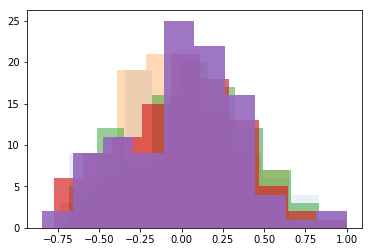

In [212]:
KNN_CV_scores = []

kf = KFold(n_splits=5,  random_state=42)
for split_id, splits in enumerate(kf.split(df,target)):
    train, test = splits
    df_train = df[train]
    target_train = target[train]
    df_test = df[test]
    target_test = target[test]
    
    cutoff_correlation = np.quantile(abs(np.corrcoef(df_train.T,target_train.T)[:,1]), 1 - 100/p)
    highest_corr_predictors_mask = abs(np.corrcoef(df_train.T,target_train.T)[:,1]) > cutoff_correlation
    
    highest_corr_predictors = df_train[:,highest_corr_predictors_mask[1:]]
    
    # build multivariate classifier AND 
    KNN = KNeighborsClassifier(n_neighbors=1, n_jobs = -1)
    KNN.fit(highest_corr_predictors,target_train)
    KNN_pred = KNN.predict(df_test[:,highest_corr_predictors_mask[1:]])
    KNN_CV_scores.append(accuracy_score(target_test, KNN_pred))
    
    # for each split calculate correlation coefficient
    # plt.figure() # if into separate plots
    plt.hist(np.corrcoef(df_test[:,highest_corr_predictors_mask[1:]].T,target_test.T)[1,:], alpha = 0.1 + split_id / 5)

### Does Cross-Validation Really Work?
* textbook reference

## Bootstrap Methods
* general tool for assessing statistical accuracy 
* typically esimates well only the expected prediction error
* basic idea: randomly draw datasets with replacement from the training data

In [217]:
# generate toy regression data 
N = 50
p = 100

X, y = datasets.make_regression(n_samples = N,
                         n_features = p,
                        n_informative = 10,
                        n_targets=1)

In [218]:
# manual bootstrap
def bootstrap_resample(X, n=None):
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [219]:
bootstrap_resample(X);

In [220]:
# using sklearn.utils.resample
B = 20
bootstrap_collector = []
for i in range(0,B):
    b_sample = resample(X,y, replace = True, n_samples = N, random_state = 42)
    X, y = b_sample[0], b_sample[1]
    S_x = np.mean(X)
    bootstrap_collector.append(S_x) # S(Z) quantity computed on data 
bs_collector = np.array(bootstrap_collector)

In [221]:
((bs_collector - bs_collector.mean())**2).sum() / (len(bs_collector) - 1)

0.00016220486852820353

* how to apply the bootstrap to estimate prediction error?
* (7.54) bootstrap error problematic
* the bootstrap datasets are acting as the training samples, while the original training is acting as the test sample (some common observations)
    * overlap can make overfit predictions look unrealistically good (reason for CV relying on nonoverlapping observations)

### 0.62 thing

*On average, each bootstrap sample makes use of around two-thirds of the observations.* 

* the probability that the first bootstrap observation is not the j-th observation from the original sample
    * $\pi_j = 1 - \frac{1}{n}$ (as P of selecting a particular $x_j$ from the set $x_1, x_2, ..., x_n$ is $1/n$)
    * prob. that the second bootstrap observation is not the j-th observation from the original sample is again $\pi_j$ (independence)
* the probability that the j-th observation is not in the bootstrap sample, i.e. j-th observation is not the 1st and not the 2nd, etc. bootstrap obs.
    * $p_j(n) =\prod_{i=1}^{n}\pi_j = (1 - \frac{1}{n})^n$

* based on $e^x = \lim_{n \rightarrow \infty} (1 + \frac{x}{n})^n$
    * $p_j = \lim_{n \rightarrow \infty}1 - p_j(n) = 1 - e^{-1} \approx 0.632$ converges to

In [21]:
def probability(n):
    return 1 - (1 - 1/n)**n

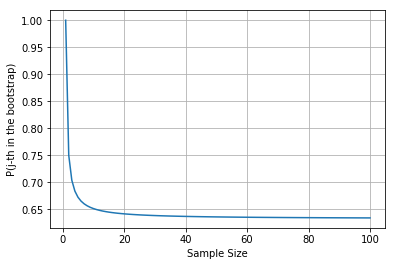

In [26]:
n = np.arange(1,101)
p = probability(n)
plt.plot(n,p)
plt.xlabel('Sample Size')
plt.ylabel('P(j-th in the bootstrap)')           
plt.grid()

* better bootstrap can be obtained 
    * only keep track of predictions from bootstrap samples not containing that observation
### The Leave-one-out Bootstrap estimate of prediction error
* $\hat{Err}$ is obtained through
$$\hat{Err} = \frac {1}{N} \displaystyle\sum_{i=1}^{N} \frac {1}{|C^{-i}|} \displaystyle\sum_{b \in {C^{-i}}} L(y_{i}, \hat{f}^{*b}(x_{i})).$$

Where
* $N$ denotes the sample size.
* $b$ denotes a specific bootstrap sample, whereas $B$ denotes the set of bootstrap samples.
* $C^{-i}$ denotes the number of bootstrap samples $b$ where observation $i$ is not contained in.
* $\hat{f}^{*b}(x_{i})$ denotes the estimated value of target $y_{i}$ by model $\hat{f}$ based on bootstrap sample $b$ and data $x_{i}$.
* $L(y_{i}, \hat{f}^{*b}(x_{i}))$ denotes the loss-function between real value $y_{i}$ and estimated value $\hat{f}^{*b}(x_{i})$

* when computing $\hat{Err}$
    * choose B large enough to ensure that all of the $|C−i|$ are greater than zero
    * leave out terms corresponding to $|C−i|$ that are 0
* the LOO bootstrap solves the overfitting problem of bootstrap mentioned earlier
    * still has the training-set-size bias mentioned earlier (similar to 2-fold CV)
        * if the learning curve has considerable slope at sample size $N/2$, the leave-one out bootstrap will be biased upward as an estimate of the true error



* the .632 estimator should dampen this bias by "pulling" LOO bootstrap estimate down toward the training error rate, and hence reduces its upward bias
    $\bar{Err} = 0.632*\hat{Err} + 0.368*inSampleError$


This is computationally intensive but when forced to work with a small data set where cross-validation is unreasonable. Estimating the test error through the bootstrap is  a viable option. 

* TODO: theoretical 0.632+ estimator?

## Conditional or Expected Test Error? (O)
*Does cross-validation do a good job in estimating $Err_{\tau}$ (the error conditional on a given training set $\tau$) as opposed to the expected test error?*

* [clarifying?](https://stats.stackexchange.com/questions/86955/the-meaning-of-conditional-test-error-vs-expected-test-error-in-cross-validatio)

* TODO: clean-up

In [92]:
N = 80
p = 20

X = np.random.uniform(low=0.0, high=1.0, size=(N,p))

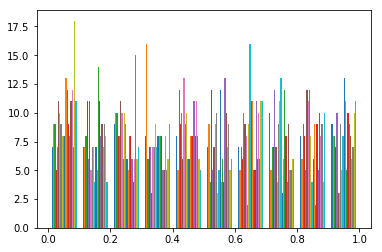

In [93]:
plt.hist(X);

In [94]:
Y_left = (X[:,0] > 0.5).astype(float)
Y_left

array([1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1.])

In [112]:
neigh = KNeighborsClassifier(n_neighbors=1, metric= 'euclidean')

In [126]:
train_scores, valid_scores = validation_curve(neigh, X, Y_left,"n_neighbors",
                                        np.arange(1, 50, 1),
                                        scoring = 'accuracy',
                                        cv=5)

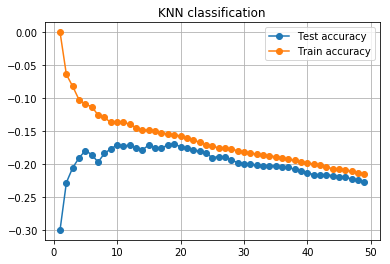

In [139]:
# inverse plot since we have -Loss function
plt.plot(np.arange(1, 50, 1),valid_scores.mean(axis = 1), '-o')
plt.plot(np.arange(1, 50, 1),train_scores.mean(axis = 1), '-o')
plt.legend(['Test accuracy', 'Train accuracy'])
plt.title('KNN classification')
plt.grid();

In [136]:
neigh_reg = KNeighborsRegressor(n_neighbors=1, metric= 'euclidean')
train_scores, valid_scores = validation_curve(neigh_reg , X, Y_left,"n_neighbors",
                                        np.arange(1, 50, 1),
                                        scoring = 'neg_mean_squared_error',
                                        cv=5)

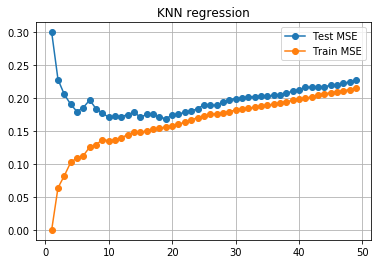

In [140]:
# inverse plot since we have -Loss function
plt.plot(np.arange(1, 50, 1), - valid_scores.mean(axis = 1), '-o')
plt.plot(np.arange(1, 50, 1), - train_scores.mean(axis = 1), '-o')
plt.legend(['Test MSE', 'Train MSE'])
plt.title('KNN regression')
plt.grid();

In [95]:
Y_right = (X[:,0:10].sum(axis = 1) > 5).astype(float)
Y_right

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])

In [145]:
best_subset = SelectKBest(f_regression, k=20)
lm = LinearRegression()
best_lr = make_pipeline(best_subset,lm)
# best_lr.fit(X, Y_right)

In [147]:
best_lr.get_params()

{'memory': None,
 'steps': [('selectkbest',
   SelectKBest(k=20, score_func=<function f_regression at 0x000000000ABB7400>)),
  ('linearregression',
   LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False))],
 'selectkbest': SelectKBest(k=20, score_func=<function f_regression at 0x000000000ABB7400>),
 'linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'selectkbest__k': 20,
 'selectkbest__score_func': <function sklearn.feature_selection.univariate_selection.f_regression(X, y, center=True)>,
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': False}

In [149]:
train_scores, valid_scores = validation_curve(best_lr, X,  Y_right,"k",
                                        np.arange(1, 19, 1),
                                        scoring = 'neg_mean_squared_error',
                                        cv=5);

ValueError: Invalid parameter k for estimator Pipeline(memory=None,
     steps=[('selectkbest', SelectKBest(k=20, score_func=<function f_regression at 0x000000000ABB7400>)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]). Check the list of available parameters with `estimator.get_params().keys()`.